This tutorial will demonstrate how to pre-process single-cell raw UMI counts to generate expression matrices that can be used as input to cell-cell communication tools. We recommend the [quality control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) chapter in the Single-cell Best Practices book as a starting point for a detailed overview of QC and single-cell RNAseq analysis pipelines in general. 

Here we will focus on:
1. Normalization
2. Inter-operability between R and python. 

We demonstrate a typical workflow using the popular single-cell analysis software [scanpy](https://scanpy.readthedocs.io/en/stable/) to generate an AnnData object which can be used downstream. We will use a [BALF COVID dataset](https://doi.org/10.1038/s41591-020-0901-9), which contains 12 samples associated with "Healthy Control", "Moderate", or "Severe" COVID contexts.

Details and caveats regarding [batch correction](https://www.nature.com/articles/s41592-018-0254-1), which removes technical variation while preserving biological variation between samples, can be viewed in the additional examples tutorial entitled "S1_Batch_Correction".

## Preparare the object for cell-cell communication analysis

Here, I just do the basic processing as it makes sense to me to be seperate from the scoring function chapter

In [1]:
import os

import scanpy as sc
import pandas as pd
import numpy as np

import cell2cell as c2c

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = '/data/hratch/ccc_protocols/interim/' #'../../data/' #<-uncomment in final

#### Loading

The 12 samples can be downloaded as .h5 files from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926). You can also download the cell metadata from [here](https://raw.githubusercontent.com/zhangzlab/covid_balf/master/all.cell.annotation.meta.txt)

Alternatively, cell2cell has a helper function to load the data as an AnnData object:

In [4]:
adata = c2c.datasets.balf_covid()

In [5]:
adata

AnnData object with n_obs × n_vars = 63103 × 33538
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition'

In [6]:
adata.obs.head()

,sample,sample_new,group,disease,hasnCoV,cluster,celltype,condition
AAACCCACAGCTACAT_3,C100,HC3,HC,N,N,27.0,B,Control
AAACCCATCCACGGGT_3,C100,HC3,HC,N,N,23.0,Macrophages,Control
AAACCCATCCCATTCG_3,C100,HC3,HC,N,N,6.0,T,Control
AAACGAACAAACAGGC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control
AAACGAAGTCGCACAC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control


#### Basic Filtering

Exclude cells that visually do not fall within the normal range of standard QC metrics (see [chapter](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)) -- fraction of genes in a cell that are mitochondrial, number of unique genes, and total number of genes measured. 

**Note, had to change n_genes_by_counts to n_genes to match the seurat filtering**

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

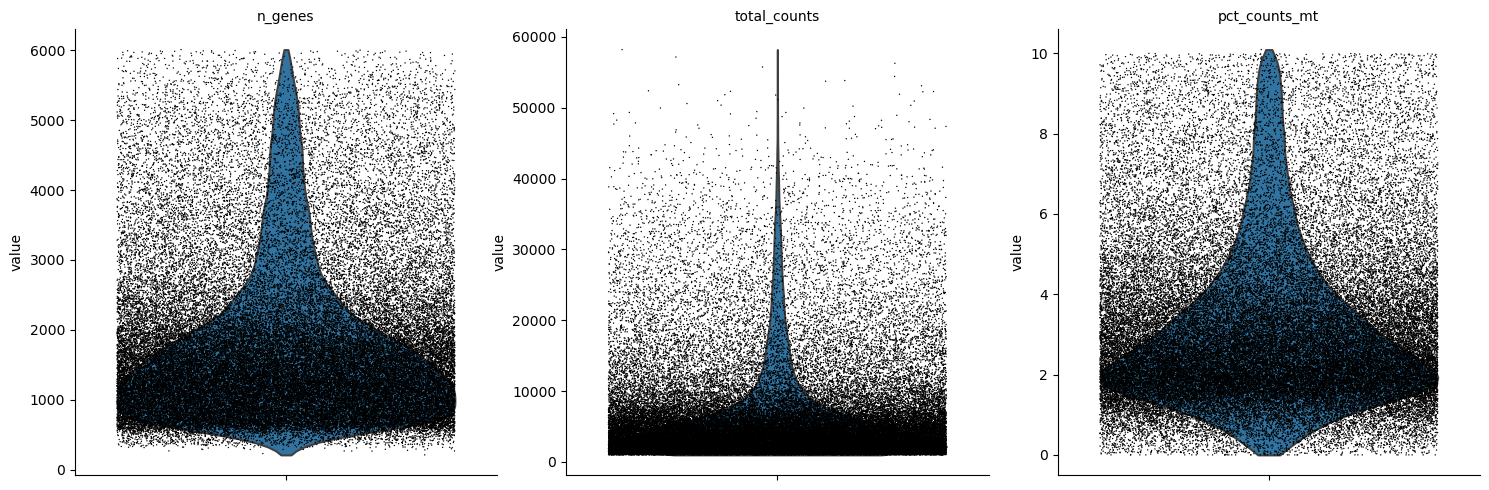

In [9]:
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

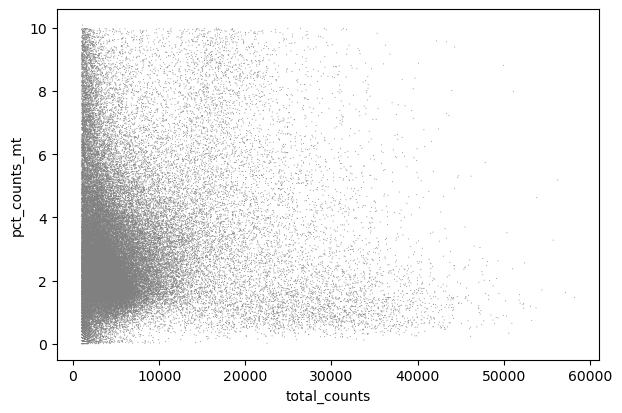

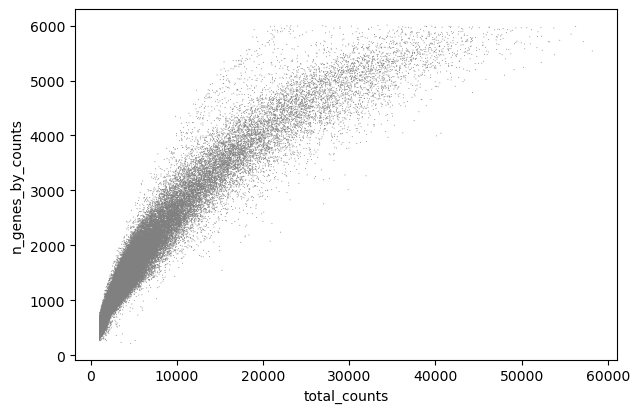

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
adata = adata[adata.obs.n_genes < 5500, :] 
adata = adata[adata.obs.pct_counts_mt < 15, :]

#### Normalize

For single-cell inference across sample and across cell types, most CCC tools require the library sizes to be comparable. We can use the scanpy function `sc.pp.normalize_total` to normalize the library sizes. This function divides each cell by the total counts per cell and multiplies by the median of the total counts per cell. Furthermore, we log1p-transform the data to make it more Gaussian-like, as this is a common assumption for the analyses downstream. Finally, such a normalization maintains non-negative counts, which is important for tensor decomposition.

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy() # copy the normalized data to adata.layers["logcounts"]

In [13]:
ordered_genes = sorted(adata.var.index)
adata.to_df().T.loc[ordered_genes,:].head()

,AAACCCACAGCTACAT_3,AAACCCATCCACGGGT_3,AAACCCATCCCATTCG_3,AAACGAACAAACAGGC_3,AAACGAAGTCGCACAC_3,AAACGAAGTCTATGAC_3,AAACGAAGTGTAGTGG_3,AAACGCTGTCACGTGC_3,AAACGCTGTTGGAGGT_3,AAAGAACTCTAGAACC_3,...,TTTGTCAGTGTCAATC_2,TTTGTCAGTGTGAAAT_2,TTTGTCATCAGTTAGC_2,TTTGTCATCCAGTATG_2,TTTGTCATCCCTAATT_2,TTTGTCATCGATAGAA_2,TTTGTCATCGGAAATA_2,TTTGTCATCGGTCCGA_2,TTTGTCATCTCACATT_2,TTTGTCATCTCCAACC_2
A1BG,0.0,0.0,0.0,0.276642,0.578448,0.0,0.0,0.0,0.470379,0.000000,...,0.0,0.0,0.0,1.753239,0.0,0.0,0.0,0.0,0.000000,0.0
A1BG-AS1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A2M,0.0,0.0,0.0,0.821883,0.000000,0.0,0.0,0.0,0.000000,1.614997,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.695685,0.0
A2M-AS1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A2ML1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


Next, we can filter for highly variable genes (HVGs). Since CCC inference tools only consider a subset of the genes (those present in ligand-receptor databases), if you find yourself not identifying enough LR interactions, you may skip this step to input a larget gene list. 

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

#### Dimensionality Reduction

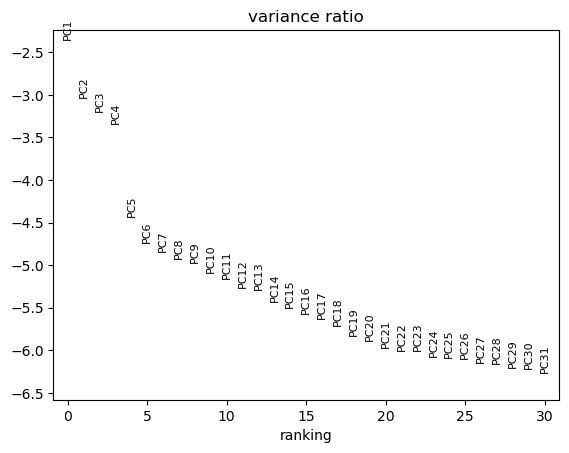

In [15]:
# pca
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [16]:
# neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
# umap
sc.tl.umap(adata)

Of course, would be better to replot the UMAP with integrated data :) - I just needed the normalized counts for the second chapter :) ##TODO

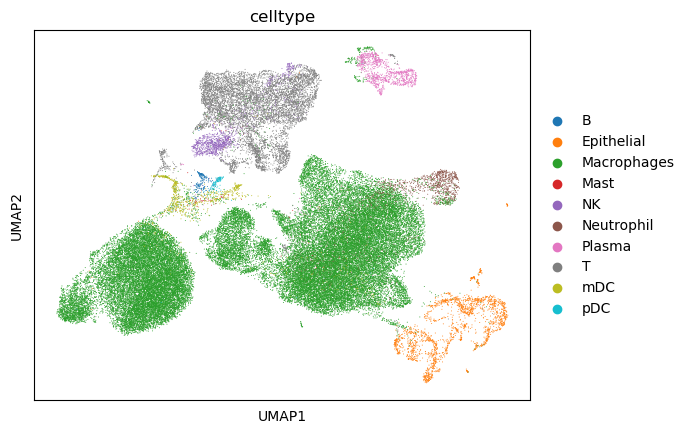

In [17]:
# plot pre-annotated cell types
sc.pl.umap(adata, color=['celltype']) ###

Save the data for downsteam analysis

In [18]:
adata.write_h5ad(os.path.join(data_path, 'processed.h5ad'))

# Interoperability

## to R

For use in R, the .h5ad file saved in the above cell can be loaded in R as a SeuratObject using SeuratDisk. See the companion R tutorial for loading these saved files.

## from R

Here, we can load the data that was generated in the companion R script using Seurat and saved as h5ad files:

In [19]:
file_name = os.path.join(data_path, 'processed_fromR_toPython.h5ad')
adata_fromR = sc.read_h5ad(file_name)